In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()

from config import Config
config = Config.load()

In [2]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

In [3]:
from utils import prompt_loader
prompt_loader.list_prompts()


2025-05-29 18:05:49,976 - utils.prompt_loader - INFO - Preloaded prompt: search.j2
2025-05-29 18:05:49,982 - utils.prompt_loader - INFO - Preloaded prompt: summarise_news.j2


['search', 'summarise_news']

### Step1: Search News

In [4]:
SEARCH_PROMPT = await prompt_loader.get_prompt("search").template.render_async()

In [5]:
from data_model.news import NewsArticleList
llm = ChatOpenAI(model=config.openai_search_tools.model)
tool = {"type": config.openai_search_tools.type, 
        "search_context_size": config.openai_search_tools.search_context_size}
function_calling_llm = llm.bind_tools([tool], parallel_tool_calls=False)
structured_output_llm = function_calling_llm.with_structured_output(NewsArticleList)
response = await structured_output_llm.ainvoke(SEARCH_PROMPT, config={"callbacks": [langfuse_handler]})

In [6]:
response.articles

[NewsArticle(title="OpenAI Launches Custom GPT-4o Models and 'Team' Workspace", source='OpenAI', date=datetime.date(2024, 6, 20), url='https://openai.com/blog/new-gpt-4o-features-for-teams', summary='OpenAI released new features centered around GPT-4o, including the ability for enterprise and team users to deploy customized GPT-4o models for specific organizational needs. This includes model fine-tuning tools aimed at boosting developer and researcher workflows in production settings.'),
 NewsArticle(title="Google Research Debuts 'Machine Unlearning Benchmarks' (MUBench)", source='Google Research', date=datetime.date(2024, 6, 18), url='https://ai.googleblog.com/2024/06/introducing-machine-unlearning-benchmarks.html', summary="Google released MUBench, a first-of-its-kind benchmark suite for evaluating 'machine unlearning' algorithms—techniques that efficiently remove the influence of specific data samples from trained models. MUBench provides standardized data and evaluation metrics, ad

### Step2: Detail Summary for Each Topic

In [12]:
summary_prompt = prompt_loader.get_prompt("summarise_news")


In [15]:
results = []
for article in response.articles:
    summarised_prompt = await summary_prompt.template.render_async(title=article.title, 
                source=article.source, 
                date=article.date, 
                summary=article.summary,
                url_ref=article.url)
    results.append(await function_calling_llm.ainvoke(summarised_prompt))

In [18]:
print(results[1].content[0]["text"])

## 📰 Meta AI Introduces V-JEPA: High-Performance Video Representation Learner, Checkpoints Released

**Source**: Meta AI  
**Date**: 2024-06-19  
**URL**: [https://ai.meta.com/blog/v-jepa-foundation-model-vision-representation-learning/](https://ai.meta.com/blog/v-jepa-foundation-model-vision-representation-learning/)

---

### 🔹 What Happened

Meta AI unveiled V-JEPA, a new foundation model for learning spatiotemporal video representations from large-scale, unlabelled video data. The model and its pretrained checkpoints have been open-sourced for the research community, enabling rapid experimentation and advancement in video understanding tasks.

### 🔹 Why It Matters

V-JEPA's ability to learn from raw video data without labels marks a step forward in self-supervised learning, potentially reducing the reliance on costly annotated datasets. By outperforming existing methods in zero-shot and few-shot scenarios, V-JEPA facilitates broader adoption of advanced video analysis techniques in

### Push

In [7]:
from agent.tools.python_executor import SecurePythonExecutorTool
python_executor = SecurePythonExecutorTool()
python_executor.invoke(
    """
import math
output = math.sqrt(128)
return output
"""
)


{'success': True,
 'output': '',
 'result': 11.313708498984761,
 'locals': {'os': namespace(listdir=<function posix.listdir(path=None)>),
  '_secure_exec_wrapper': <function _secure_exec_wrapper()>,
  '_final_execution_result': 11.313708498984761}}

In [8]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
import os

# reference: https://github.com/langchain-ai/langchain-mcp/blob/main/examples/langgraph-mcp.ipynb

client = MultiServerMCPClient(
    {
        "github": {
            "command": "docker",
            # Replace with absolute path to your math_server.py file
            "args": [
            "run",
            "-i",
            "--rm",
            "-e",
            "GITHUB_PERSONAL_ACCESS_TOKEN",
            "ghcr.io/github/github-mcp-server"],
            "env": {
                "GITHUB_PERSONAL_ACCESS_TOKEN": os.getenv("GITHUB_PERSONAL_ACCESS_TOKEN"),
                **os.environ,
            },
            "transport": "stdio",
        }
    }
)


In [9]:
tools = await client.get_tools()


In [10]:
tools.append(python_executor)
tools.append(tool)

In [13]:
article = response.articles[0]
summarised_prompt = await summary_prompt.template.render_async(title=article.title, 
                source=article.source, 
                date=article.date, 
                summary=article.summary,
                url_ref=article.url)

In [18]:
summarised_prompt

"You are an expert AI news summarizer. Based on the article below, generate a clean, markdown-formatted report.\n\nThe report must follow the structure below and should be ready for saving as a `.md` file.\nNote: do not include ```markdown in the summary.\n\n\nFocus on:\n- Key event and its importance\n- Any technical details (models, methods, data)\n- Extracting **benchmark results** and formatting them in a markdown table (if present)\n- Listing **relevant reference links** (e.g., papers, blog posts, GitHub)\n\n---\n\n## 📰 OpenAI Launches Custom GPT-4o Models and 'Team' Workspace\n\n**Source**: OpenAI  \n**Date**: 2024-06-20  \n**URL**: [https://openai.com/blog/new-gpt-4o-features-for-teams](https://openai.com/blog/new-gpt-4o-features-for-teams)\n**Summary**: OpenAI released new features centered around GPT-4o, including the ability for enterprise and team users to deploy customized GPT-4o models for specific organizational needs. This includes model fine-tuning tools aimed at boosti

In [19]:
agent = create_react_agent(
    "openai:gpt-4.1",
    tools,
    debug=True
)



In [23]:
prompt = f"""
There are few steps to complete the task:

1.{summarised_prompt}

2. Locate my GitHub repository named `leetcode-cookbook` (username: jeff52415) using the GitHub API or CLI — do not search via github.com. Then create a readme file under problems directory to include record your summarized news.
"""

In [24]:
print(prompt)


There are few steps to complete the task:

1.You are an expert AI news summarizer. Based on the article below, generate a clean, markdown-formatted report.

The report must follow the structure below and should be ready for saving as a `.md` file.
Note: do not include ```markdown in the summary.


Focus on:
- Key event and its importance
- Any technical details (models, methods, data)
- Extracting **benchmark results** and formatting them in a markdown table (if present)
- Listing **relevant reference links** (e.g., papers, blog posts, GitHub)

---

## 📰 OpenAI Launches Custom GPT-4o Models and 'Team' Workspace

**Source**: OpenAI  
**Date**: 2024-06-20  
**URL**: [https://openai.com/blog/new-gpt-4o-features-for-teams](https://openai.com/blog/new-gpt-4o-features-for-teams)
**Summary**: OpenAI released new features centered around GPT-4o, including the ability for enterprise and team users to deploy customized GPT-4o models for specific organizational needs. This includes model fine-tu

In [25]:
result = await agent.ainvoke(
    {"messages": [{"role": "user", "content": prompt}]}
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [{'content': '\n'
                          'There are few steps to complete the task:\n'
                          '\n'
                          '1.You are an expert AI news summarizer. Based on '
                          'the article below, generate a clean, '
                          'markdown-formatted report.\n'
                          '\n'
                          'The report must follow the structure below and '
                          'should be ready for saving as a `.md` file.\n'
                          'Note: do not include ```markdown in the summary.\n'
                          '\n'
                          '\n'
                          'Focus on:\n'
                          '- Key event and its importance\n'
                          '- Any technical details (models, methods, data)\n'
                          '- Extracting **benchma

In [37]:
result["messages"][7]

AIMessage(content=[{'type': 'text', 'text': 'Here\'s the requested news summary in markdown format:\n\n---\n\n## 📰 OpenAI Launches Custom GPT-4o Models and \'Team\' Workspace\n\n**Source**: OpenAI  \n**Date**: 2024-06-20  \n**URL**: [https://openai.com/blog/new-gpt-4o-features-for-teams](https://openai.com/blog/new-gpt-4o-features-for-teams)\n\n**Summary**: OpenAI has unveiled new GPT-4o features for enterprise and team users, most notably enabling the deployment of custom GPT-4o models tailored to organizational needs. Alongside model customization, the release introduces a collaborative "Team" workspace and advanced fine-tuning tools aimed at enhancing productivity for developers and researchers in production environments.\n\n---\n\n### 🔹 What Happened\n\nOpenAI introduced new capabilities around GPT-4o, allowing organizations to create and manage customized versions of the model. These enhancements also include collaborative tools for teams and scalable infrastructure for large orga

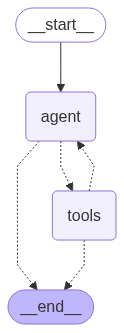

In [45]:
agent.